# ShopCo
## Predicting Fraud with Imbalanced Data

In [46]:
import os 
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import ClassBalance
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import CVScores
from yellowbrick.features import PCADecomposition
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.features import ParallelCoordinates
from yellowbrick.classifier import ClassificationReport 
from yellowbrick.model_selection import ValidationCurve 
from yellowbrick.model_selection import FeatureImportances

from sklearn.metrics import f1_score
from sklearn.externals import joblib
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split as tts

# About the data

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

Please cite the following works:

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
# Load the data into a Pandas dataframe
# get a sample count 
fraud_data = pd.read_csv("data/"+"creditcard.csv")
print(
    "There are {} instances contained in the dataset.".format(
        len(fraud_data)
    )
)
fraud_data.head()

There are 284807 instances contained in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fraud_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# Assume the store is online and thus technically always open
first_purchase = datetime.datetime(2013, 9, 1, 0, 0, 0, 0)
print(first_purchase)

2013-09-01 00:00:00


In [5]:
# Create a timestamp column using the Time (in seconds)
# from the initial purchase
fraud_data["timestamp"] = fraud_data.apply(
    lambda row: datetime.timedelta(seconds=row.Time) + first_purchase, 
    axis=1
)

In [6]:
# Create a day column using the timestamp
fraud_data["day"] = fraud_data["timestamp"].dt.to_period('D')

In [7]:
talk_colors=[
    "#41294a", "#d23733", "#e6403b", "#fef2e2",
    "#fde5c5", "#f7b100", "#f39904"
]
talk_palette = sns.color_palette(talk_colors)

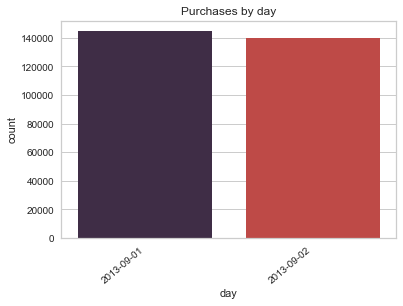

In [8]:
ax = sns.countplot(
    x="day", 
    data=fraud_data,
    palette=talk_palette
)
ax.set_title("Purchases by day")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [9]:
# Create an hour column using the timestamp
fraud_data["hour"] = fraud_data["timestamp"].dt.to_period('H')

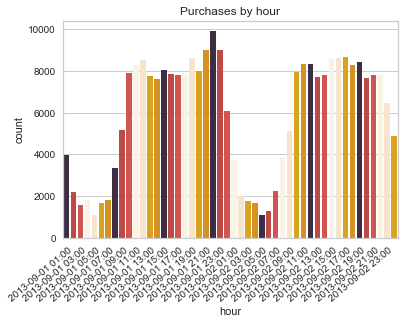

In [10]:
ax = sns.countplot(
    x="hour", 
    data=fraud_data,
    palette=talk_palette
)
ax.set_title("Purchases by hour")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.show()

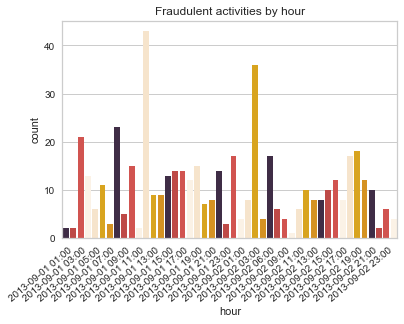

In [11]:
# Is fraud more common at certain times of day? 
ax = sns.countplot(
    x="hour",
    data=fraud_data[fraud_data["Class"] == 1],
    palette=talk_palette
)
ax.set_title("Fraudulent activities by hour")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.show()

# Target analysis

In [76]:
# Reduce feature space to metrics only for preliminary model 
features = [
    "V1", "V2", "V3", "V4", "V5", "V6", 
    "V7", "V8", "V9", "V10", "Amount"
]
classes = ["Non-Fraud", "Fraud"]

# Separate the features from the target values
X = fraud_data[features].values
y = fraud_data["Class"].values

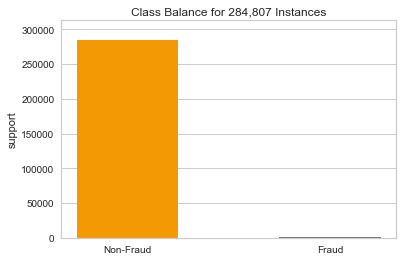

In [77]:
# Let's check to see how balanced our classes our,
# which may help us to anticipate any modeling challenges 
# we might experience downstream in our workflow.
class_balance = ClassBalance(
    labels=classes, 
    colors=["#f39904", "#e6403b"]
)
class_balance.fit(y)
class_balance.show()

In [78]:
# The data are very imbalanced!
fraud_cases = fraud_data[fraud_data["Class"] == 1]
print(
    "Thankfully, fraud only occurred in {} percent of cases.".format(
        len(fraud_cases)/len(fraud_data) * 100
    )
)

Thankfully, fraud only occurred in 0.1727485630620034 percent of cases.


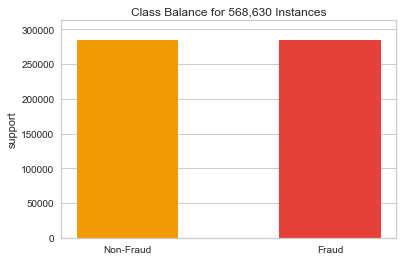

In [79]:
# Oversample the minority class 
smote = SMOTE(random_state=42)
X_up, y_up = smote.fit_resample(X, y)
class_balance = ClassBalance(
    labels=classes, 
    colors=["#f39904", "#e6403b"]
)
class_balance.fit(y_up)
class_balance.show()

# Feature Analysis and Wrangling

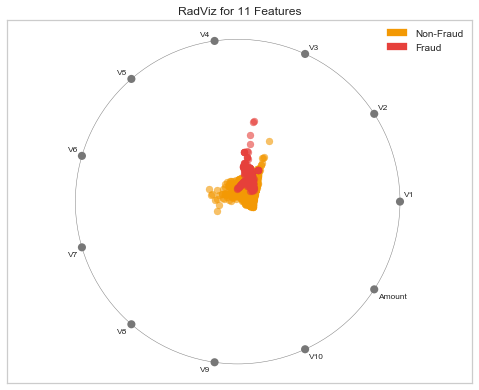

In [80]:
# Next we want to determine if there is separability in the data 
# in other words, will we be able to differentiate them using
# the features.
radviz = RadViz(
     classes=classes, features=features, alpha=0.6,
     colors=["#f39904", "#e6403b"], size=(600, 480)
 )
radviz.fit(X, y)
radviz.transform(X)
radviz.show()

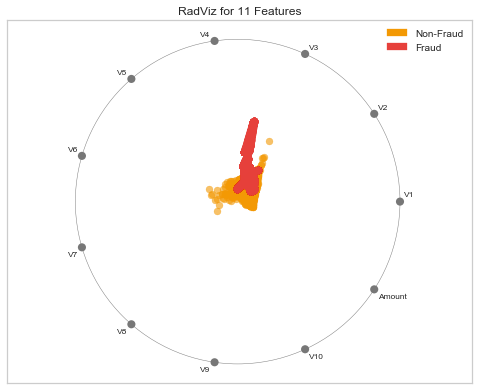

In [81]:
radviz = RadViz(
     classes=classes, features=features, alpha=0.6,
     colors=["#f39904", "#e6403b"], size=(600, 480)
 )
radviz.fit(X_up, y_up)
radviz.transform(X_up)
radviz.show()

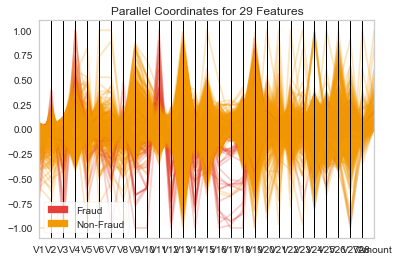

In [24]:
# Next we want to determine if there is separability in the data 
# in other words, will we be able to differentiate them using
# the features.
pcoords = ParallelCoordinates(
    classes=classes, features=features, sample=0.05,
    shuffle=True, normalize="minmax", size=(900, 480),
    colors=["#f39904", "#e6403b"]
)
pcoords.fit_transform(X, y)
pcoords.show()

KeyboardInterrupt: 

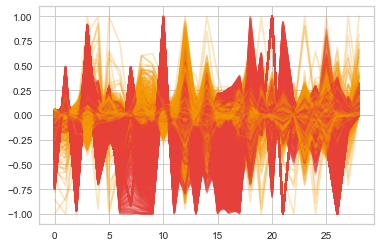

In [25]:
pcoords = ParallelCoordinates(
    classes=classes, features=features, sample=0.05,
    shuffle=True, normalize="minmax", size=(900, 480),
    colors=["#f39904", "#e6403b"]
)
pcoords.fit_transform(X_up, y_up)
pcoords.show()

In [ ]:
#Let's see if any of the features display pairwise relationships 
rank2d = Rank2D(
    algorithm="covariance", features=features,
    size=(600, 480), colormap="autumn"
)
rank2d.fit(X, y)
rank2d.transform(X)
rank2d.show()

In [ ]:
rank2d = Rank2D(
    algorithm="covariance", features=features,
    size=(600, 480), colormap="autumn"
)
rank2d.fit(X_up, y_up)
rank2d.transform(X_up)
rank2d.show()

# Feature Elimination

In [26]:
rfe = RFE(
    RandomForestClassifier(n_estimators=10), 
    n_features_to_select=5, 
    step=1
)
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=5, step=1, verbose=0)

In [27]:
rfe.support_

array([False, False, False,  True, False, False,  True, False, False,
       False, False,  True, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [28]:
rfe.ranking_

array([17, 24,  6,  1, 22,  7,  1, 15,  5,  2,  8,  1, 18,  1, 20,  4,  1,
       19, 11,  9, 10, 21, 25, 23, 12,  3, 16, 14, 13])

In [29]:
rfe = RFE(
    RandomForestClassifier(n_estimators=10), 
    n_features_to_select=5, 
    step=1
)
rfe.fit(X_up, y_up)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=5, step=1, verbose=0)

In [30]:
rfe.support_

array([False, False, False,  True, False, False, False, False, False,
        True, False,  True, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [31]:
rfe.ranking_

array([ 4, 11,  2,  1,  7,  9, 13,  6, 14,  1,  5,  1, 12,  1, 16,  8,  1,
       15, 17, 18, 21, 25, 23, 22, 20, 19, 24, 10,  3])

# PCA

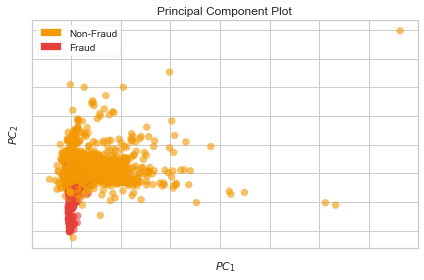

In [37]:
pca = PCADecomposition(
    scale=True, 
    classes=classes, 
    colors=["#f39904", "#e6403b"],
    alpha=.6
)
pca.fit_transform(X, y)
pca.show()

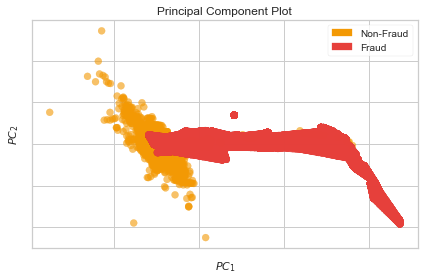

In [38]:
pca = PCADecomposition(
    scale=True, 
    classes=classes, 
    colors=["#f39904", "#e6403b"],
    alpha=.6
)
pca.fit_transform(X_up, y_up)
pca.show()

# Modeling

In [39]:
models = [
    ExtraTreesClassifier(n_estimators=10),
    RandomForestClassifier(n_estimators=10),
    GradientBoostingClassifier(n_estimators=10)
] 

In [44]:
X_train, X_test, y_train, y_test = tts(
    X, y, test_size=0.33, random_state=42
)

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        "{}:{}".format(
            model.__class__.__name__, 
            f1_score(y_test, y_pred)
        )
    )

ExtraTreesClassifier:0.8283582089552239
RandomForestClassifier:0.8296296296296296
GradientBoostingClassifier:0.7835051546391754


In [45]:
X_train, X_test, y_train, y_test = tts(
    X_up, y_up, test_size=0.33, random_state=42
)

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        "{}:{}".format(
            model.__class__.__name__, 
            f1_score(y_test, y_pred)
        )
    )

ExtraTreesClassifier:0.999904134977951
RandomForestClassifier:0.9998349000079888
GradientBoostingClassifier:0.9504383788254755


In [65]:
# yellowbrick.classifier.rocauc
# Implements visual ROC/AUC curves for classification evaluation.
#
# Author:   Rebecca Bilbro
# Author:   Benjamin Bengfort
# Author:   Neal Humphrey
# Created:  Tue May 03 18:15:42 2017 -0400
#
# Copyright (C) 2016 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: rocauc.py [5388065] neal@nhumphrey.com $

"""
Implements visual ROC/AUC curves for classification evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np

from scipy import interp
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import label_binarize

from yellowbrick.exceptions import ModelError
from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.classifier.base import ClassificationScoreVisualizer


# Dictionary keys for ROCAUC
MACRO = "macro"
MICRO = "micro"


##########################################################################
## ROCAUC Visualizer
##########################################################################


class ROCAUC(ClassificationScoreVisualizer):
    """
    Receiver Operating Characteristic (ROC) curves are a measure of a
    classifier's predictive quality that compares and visualizes the tradeoff
    between the models' sensitivity and specificity. The ROC curve displays
    the true positive rate on the Y axis and the false positive rate on the
    X axis on both a global average and per-class basis. The ideal point is
    therefore the top-left corner of the plot: false positives are zero and
    true positives are one.
    This leads to another metric, area under the curve (AUC), a computation
    of the relationship between false positives and true positives. The higher
    the AUC, the better the model generally is. However, it is also important
    to inspect the "steepness" of the curve, as this describes the
    maximization of the true positive rate while minimizing the false positive
    rate. Generalizing "steepness" usually leads to discussions about
    convexity, which we do not get into here.
    Parameters
    ----------
    model : estimator
        A scikit-learn estimator that should be a classifier. If the model is
        not a classifier, an exception is raised. If the internal model is not
        fitted, it is fit when the visualizer is fitted, unless otherwise specified
        by ``is_fitted``.
    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If not specified the current axes will be
        used (or generated if required).
    micro : bool, default: True
        Plot the micro-averages ROC curve, computed from the sum of all true
        positives and false positives across all classes. Micro is not defined
        for binary classification problems with estimators with only a
        decision_function method.
    macro : bool, default: True
        Plot the macro-averages ROC curve, which simply takes the average of
        curves across all classes. Macro is not defined for binary
        classification problems with estimators with only a decision_function
        method.
    per_class : bool, default: True
        Plot the ROC curves for each individual class. This should be set
        to false if only the macro or micro average curves are required. Per-
        class classification is not defined for binary classification problems
        with estimators with only a decision_function method.
    classes : list of str, defult: None
        The class labels to use for the legend ordered by the index of the sorted
        classes discovered in the ``fit()`` method. Specifying classes in this
        manner is used to change the class names to a more specific format or
        to label encoded integer classes. Some visualizers may also use this
        field to filter the visualization for specific classes. For more advanced
        usage specify an encoder rather than class labels.
    encoder : dict or LabelEncoder, default: None
        A mapping of classes to human readable labels. Often there is a mismatch
        between desired class labels and those contained in the target variable
        passed to ``fit()`` or ``score()``. The encoder disambiguates this mismatch
        ensuring that classes are labeled correctly in the visualization.
    is_fitted : bool or str, default="auto"
        Specify if the wrapped estimator is already fitted. If False, the estimator
        will be fit when the visualizer is fit, otherwise, the estimator will not be
        modified. If "auto" (default), a helper method will check if the estimator
        is fitted before fitting it again.
    force_model : bool, default: False
        Do not check to ensure that the underlying estimator is a classifier. This
        will prevent an exception when the visualizer is initialized but may result
        in unexpected or unintended behavior.
    kwargs : dict
        Keyword arguments passed to the visualizer base classes.
    Attributes
    ----------
    classes_ : ndarray of shape (n_classes,)
        The class labels observed while fitting.
    class_count_ : ndarray of shape (n_classes,)
        Number of samples encountered for each class during fitting.
    score_ : float
        An evaluation metric of the classifier on test data produced when
        ``score()`` is called. This metric is between 0 and 1 -- higher scores are
        generally better. For classifiers, this score is usually accuracy, but
        if micro or macro is specified this returns an F1 score.
    Notes
    -----
    ROC curves are typically used in binary classification, and in fact the
    Scikit-Learn ``roc_curve`` metric is only able to perform metrics for
    binary classifiers. As a result it is necessary to binarize the output or
    to use one-vs-rest or one-vs-all strategies of classification. The
    visualizer does its best to handle multiple situations, but exceptions can
    arise from unexpected models or outputs.
    Another important point is the relationship of class labels specified on
    initialization to those drawn on the curves. The classes are not used to
    constrain ordering or filter curves; the ROC computation happens on the
    unique values specified in the target vector to the ``score`` method. To
    ensure the best quality visualization, do not use a LabelEncoder for this
    and do not pass in class labels.
    .. seealso::
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    .. todo:: Allow the class list to filter the curves on the visualization.
    Examples
    --------
    >>> from yellowbrick.classifier import ROCAUC
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.model_selection import train_test_split
    >>> data = load_data("occupancy")
    >>> features = ["temp", "relative humidity", "light", "C02", "humidity"]
    >>> X_train, X_test, y_train, y_test = train_test_split(X, y)
    >>> oz = ROCAUC(LogisticRegression())
    >>> oz.fit(X_train, y_train)
    >>> oz.score(X_test, y_test)
    >>> oz.show()
    """

    def __init__(
        self,
        model,
        ax=None,
        micro=True,
        macro=True,
        per_class=True,
        classes=None,
        encoder=None,
        is_fitted="auto",
        force_model=False,
        **kwargs
    ):
        super(ROCAUC, self).__init__(
            model,
            ax=ax,
            classes=classes,
            encoder=encoder,
            is_fitted=is_fitted,
            force_model=force_model,
            **kwargs
        )

        # Set the visual parameters for ROCAUC
        self.set_params(micro=micro, macro=macro, per_class=per_class)
        self.my_colors = ["#f39904", "#e6403b"]

    def score(self, X, y=None):
        """
        Generates the predicted target values using the Scikit-Learn
        estimator.
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features
        y : ndarray or Series of length n
            An array or series of target or class values
        Returns
        -------
        score_ : float
            Global accuracy unless micro or macro scores are requested.
        """
        # Call super to check if fitted and to compute self.score_
        # NOTE: this sets score to the base score if neither macro nor micro
        super(ROCAUC, self).score(X, y)

        # Compute the predictions for the test data
        y_pred = self._get_y_scores(X)

        # Note: In the above, _get_y_scores calls either a decision_function or
        # predict_proba, which should return a 2D array. But in a binary
        # classification using an estimator with only a decision_function, y_pred
        # will instead be 1D, meaning only one curve can be plotted. In this case,
        # we set the _binary_decision attribute to True to ensure only one curve is
        # computed and plotted later on.
        if y_pred.ndim == 1:
            self._binary_decision = True

            # Raise an error if it's a binary decision and user has set micro,
            # macro, or per_class to True
            if self.micro or self.macro or self.per_class:
                raise ModelError(
                    "Micro, macro, and per-class scores are not defined for "
                    "binary classification for estimators with only "
                    "decision_function methods; set micro, macro, and "
                    "per-class params to False."
                )
        else:
            self._binary_decision = False
            # If it's not a binary decision, at least one of micro, macro, or
            # per_class must be True
            if not self.micro and not self.macro and not self.per_class:
                raise YellowbrickValueError(
                    "no curves will be drawn; specify micro, macro, or per_class"
                )

        # Classes may be label encoded so only use what's in y to compute.
        # The self.classes_ attribute will be used as names for labels.
        classes = np.unique(y)
        n_classes = len(classes)

        # Store the false positive rate, true positive rate and curve info.
        self.fpr = dict()
        self.tpr = dict()
        self.roc_auc = dict()

        # If the decision is binary, compute the ROC curve and ROC area
        if self._binary_decision is True:
            self.fpr[0], self.tpr[0], _ = roc_curve(y, y_pred)
            self.roc_auc[0] = auc(self.fpr[0], self.tpr[0])
        else:
            # Otherwise compute the ROC curve and ROC area for each class
            for i, c in enumerate(classes):
                self.fpr[i], self.tpr[i], _ = roc_curve(y, y_pred[:, i], pos_label=c)
                self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])

        # Compute micro average
        if self.micro:
            self._score_micro_average(y, y_pred, classes, n_classes)

        # Compute macro average
        if self.macro:
            self._score_macro_average(n_classes)

        # Draw the Curves
        self.draw()

        # Set score to micro average if specified
        if self.micro:
            self.score_ = self.roc_auc[MICRO]

        # Set score to macro average if not micro
        if self.macro:
            self.score_ = self.roc_auc[MACRO]

        return self.score_

    def draw(self):
        """
        Renders ROC-AUC plot.
        Called internally by score, possibly more than once
        Returns
        -------
        ax : the axis with the plotted figure
        """
        colors = self.my_colors
        n_classes = len(self.my_colors)

        # If it's a binary decision, plot the single ROC curve
        if self._binary_decision is True:
            self.ax.plot(
                self.fpr[0],
                self.tpr[0],
                label="ROC for binary decision, AUC = {:0.2f}".format(self.roc_auc[0]),
            )

        # If per-class plotting is requested, plot ROC curves for each class
        if self.per_class:
            for i, color in zip(range(n_classes), colors):
                self.ax.plot(
                    self.fpr[i],
                    self.tpr[i],
                    color=color,
                    label="ROC of class {}, AUC = {:0.2f}".format(
                        self.classes_[i], self.roc_auc[i]
                    ),
                )

        # If requested, plot the ROC curve for the micro average
        if self.micro:
            self.ax.plot(
                self.fpr[MICRO],
                self.tpr[MICRO],
                linestyle="--",
                color=self.my_colors[len(self.classes_) - 1],
                label="micro-average ROC curve, AUC = {:0.2f}".format(
                    self.roc_auc["micro"]
                ),
            )

        # If requested, plot the ROC curve for the macro average
        if self.macro:
            self.ax.plot(
                self.fpr[MACRO],
                self.tpr[MACRO],
                linestyle="--",
                color=self.my_colors[len(self.classes_) - 1],
                label="macro-average ROC curve, AUC = {:0.2f}".format(
                    self.roc_auc["macro"]
                ),
            )

        # Plot the line of no discrimination to compare the curve to.
        self.ax.plot([0, 1], [0, 1], linestyle=":", c=LINE_COLOR)
        return self.ax

    def finalize(self, **kwargs):
        """
        Sets a title and axis labels of the figures and ensures the axis limits
        are scaled between the valid ROCAUC score values.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        Notes
        -----
        Generally this method is called from show and not directly by the user.
        """
        # Set the title and add the legend
        self.set_title("ROC Curves for {}".format(self.name))
        self.ax.legend(loc="lower right", frameon=True)

        # Set the limits for the ROC/AUC (always between 0 and 1)
        self.ax.set_xlim([0.0, 1.0])
        self.ax.set_ylim([0.0, 1.0])

        # Set x and y axis labels
        self.ax.set_ylabel("True Postive Rate")
        self.ax.set_xlabel("False Positive Rate")

    def _get_y_scores(self, X):
        """
        The ``roc_curve`` metric requires target scores that can either be the
        probability estimates of the positive class, confidence values or non-
        thresholded measure of decisions (as returned by "decision_function").
        This method computes the scores by resolving the estimator methods
        that retreive these values.
        .. todo:: implement confidence values metric.
        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features -- generally the test data
            that is associated with y_true values.
        """
        # The resolution order of scoring functions
        attrs = ("predict_proba", "decision_function")

        # Return the first resolved function
        for attr in attrs:
            try:
                method = getattr(self.estimator, attr, None)
                if method:
                    return method(X)
            except AttributeError:
                # Some Scikit-Learn estimators have both probability and
                # decision functions but override __getattr__ and raise an
                # AttributeError on access.
                # Note that because of the ordering of our attrs above,
                # estimators with both will *only* ever use probability.
                continue

        # If we've gotten this far, raise an error
        raise ModelError(
            "ROCAUC requires estimators with predict_proba or "
            "decision_function methods."
        )

    def _score_micro_average(self, y, y_pred, classes, n_classes):
        """
        Compute the micro average scores for the ROCAUC curves.
        """
        # Convert y to binarized array for micro and macro scores
        y = label_binarize(y, classes=classes)
        if n_classes == 2:
            y = np.hstack((1 - y, y))

        # Compute micro-average
        self.fpr[MICRO], self.tpr[MICRO], _ = roc_curve(y.ravel(), y_pred.ravel())
        self.roc_auc[MICRO] = auc(self.fpr[MICRO], self.tpr[MICRO])

    def _score_macro_average(self, n_classes):
        """
        Compute the macro average scores for the ROCAUC curves.
        """
        # Gather all FPRs
        all_fpr = np.unique(np.concatenate([self.fpr[i] for i in range(n_classes)]))
        avg_tpr = np.zeros_like(all_fpr)

        # Compute the averages per class
        for i in range(n_classes):
            avg_tpr += interp(all_fpr, self.fpr[i], self.tpr[i])

        # Finalize the average
        avg_tpr /= n_classes

        # Store the macro averages
        self.fpr[MACRO] = all_fpr
        self.tpr[MACRO] = avg_tpr
        self.roc_auc[MACRO] = auc(self.fpr[MACRO], self.tpr[MACRO])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


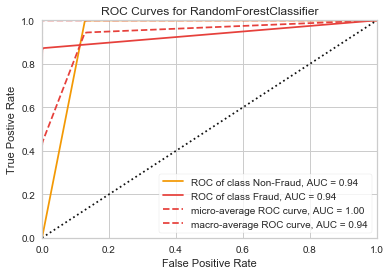

In [66]:
X_train, X_test, y_train, y_test = tts(
    X, y, test_size=0.33, random_state=42
)
rocauc = ROCAUC(
    RandomForestClassifier(n_estimators=10), 
    classes=classes, 
#     colors=["#f39904", "#e6403b"],
)

rocauc.fit(X_train, y_train)
rocauc.score(X_test, y_test)
rocauc.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


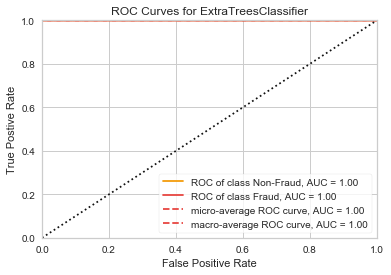

In [67]:
X_train, X_test, y_train, y_test = tts(
    X_up, y_up, test_size=0.33, random_state=42
)
rocauc = ROCAUC(
    ExtraTreesClassifier(n_estimators=10), 
    classes=classes, 
#     colors=["#f39904", "#e6403b"],
)
rocauc.fit(X_train, y_train)
rocauc.score(X_test, y_test)
rocauc.show()

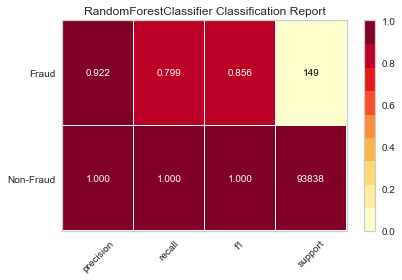

In [72]:
X_train, X_test, y_train, y_test = tts(
    X, y, test_size=0.33, random_state=42
)

clf_report = ClassificationReport(
    RandomForestClassifier(n_estimators=10), 
    classes=classes, support=True
)

clf_report.fit(X_train, y_train)
clf_report.score(X_test, y_test)
clf_report.show()    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


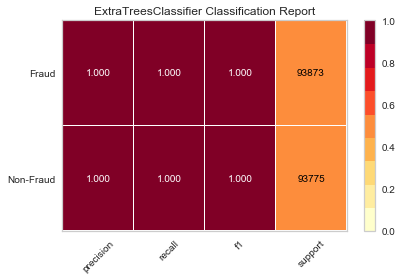

In [73]:
X_train, X_test, y_train, y_test = tts(
    X_up, y_up, test_size=0.33, random_state=42
)

clf_report = ClassificationReport(
    ExtraTreesClassifier(n_estimators=10),
    classes=classes, support=True
)

clf_report.fit(X_train, y_train)
clf_report.score(X_test, y_test)
clf_report.show()  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


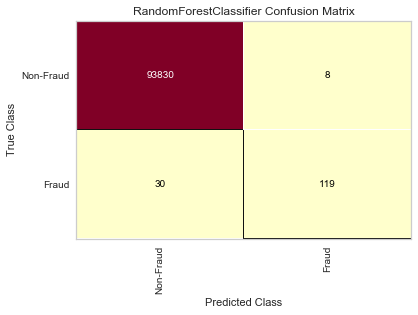

In [74]:
X_train, X_test, y_train, y_test = tts(
    X, y, test_size=0.33, random_state=42
)

clf_report = ConfusionMatrix(
    RandomForestClassifier(n_estimators=10),
    classes=classes, support=True
)

clf_report.fit(X_train, y_train)
clf_report.score(X_test, y_test)
clf_report.show() 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


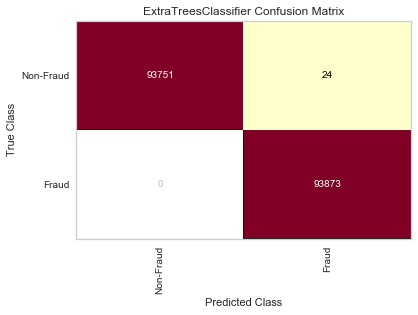

In [75]:
X_train, X_test, y_train, y_test = tts(
    X_up, y_up, test_size=0.33, random_state=42
)

clf_report = ConfusionMatrix(
    ExtraTreesClassifier(n_estimators=10),
    classes=classes, support=True
)

clf_report.fit(X_train, y_train)
clf_report.score(X_test, y_test)
clf_report.show() 